# Prédiction de séries temporelles 

Peux-t-on faire une prédiction à 5 jours sur un cours boursier ou ici cours du Bitcoin...

## Partie 1 - par régression
L'idées est de construire est d'entrainer un réseau d'apprentissage qui regardant les données sur n jours prédit le cours des p suivants. 

In [784]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt # data visualization

In [785]:
df = pd.read_csv('bitcoin.csv')

In [786]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-01,963.66,1003.08,958.70,998.33,998.33,147775008
1,2017-01-02,998.62,1031.39,996.70,1021.75,1021.75,222184992
2,2017-01-03,1021.60,1044.08,1021.60,1043.84,1043.84,185168000
3,2017-01-04,1044.40,1159.42,1044.40,1154.73,1154.73,344945984
4,2017-01-05,1156.73,1191.10,910.42,1013.38,1013.38,510199008


In [787]:
df.columns.values

array(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'],
      dtype=object)

In [788]:
df.shape

(1049, 7)

In [789]:
df_open = pd.DataFrame(df['Open'])

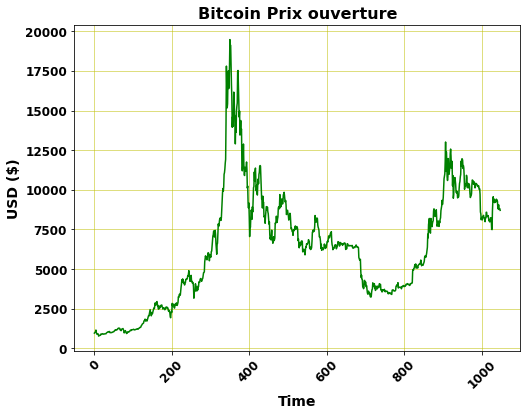

In [790]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.figure(figsize=(8, 6))
plt.plot(df_open, color='g')
plt.title('Bitcoin Prix ouverture', weight='bold', fontsize=16)
plt.xlabel('Time', weight='bold', fontsize=14)
plt.ylabel('USD ($)', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.yticks(weight='bold', fontsize=12)
plt.grid(color = 'y', linewidth = 0.5)

Création d'une fonction pour déterminer un ensemble d'apprentissage

In [828]:
def TimeSplit(Data,nin,nout,Targetname):
    # Data dataframe
    # nin nout entier
    # Targetname string
    
    # combien de ligne de sorties
    DataOutSize=Data.shape[0]-nin-nout;
    Labels=Data.columns.values[1:7]; # date en moins
    DataOut=[]
    TargetOut=[]
    for i in range(0,DataOutSize):
        out=[]
        target=[]
        for j in range(0,nin):
            for col in ["Open","Close"]: #Labels[1:7]:
                out.append(Data[col][i+j])
        DataOut.append(out)
        for j in range(0,nout):
            target.append(Data["Open"][i+nin+j])
        TargetOut.append(target)
        
    return np.array(DataOut),np.array(TargetOut)

In [829]:
nb_know = 25 #nombre de jours d'apprentissage
nb_predict= 5 # nombre de jours prédis
X,Y = TimeSplit(df,nb_know,nb_predict,"Open")

## a) scikitlearn

L'apprentissage se fait avec les 800 premiers jours et le test sur les 2049 jours restants

In [830]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics

Normalisation des données

In [831]:
scaler = StandardScaler().fit(X)
X=scaler.transform(X)

On sépare les données en 2 comme on regarde une suite temporelle on ne prend pas un échantillon au hazar,on coupe à un moment donné

In [832]:
X_train=X[0:800]   ;Y_train=Y[0:800] #set d apprentissage
X_test =X[800:len(X)];Y_test =Y[800:len(X)] # set de test

Définition et entrainement d'un modèle on se restraint à une seule couche pour éviter un sur-apprentissage

In [834]:
model_skt = MLPRegressor(solver='lbfgs', verbose =True,
                   hidden_layer_sizes=(7,5), activation= "relu", random_state=263 , max_iter = 10000000, tol=0.0001)

In [835]:
model_skt.fit(X_train,Y_train)

MLPRegressor(hidden_layer_sizes=(7, 5), max_iter=10000000, random_state=263,
             solver='lbfgs', verbose=True)

*Que dire de la précision ?* Utilisons le score R2

In [836]:
metrics.r2_score(Y_train, model_skt.predict(X_train)) # sur echantillon d'apprentissage

0.9890653715723795

In [837]:
metrics.r2_score(Y_test, model_skt.predict(X_test)) # sur echantillon test

0.8653697941206714

Le modèle ne semble pas extrêmement bon ou sur-entrainé....

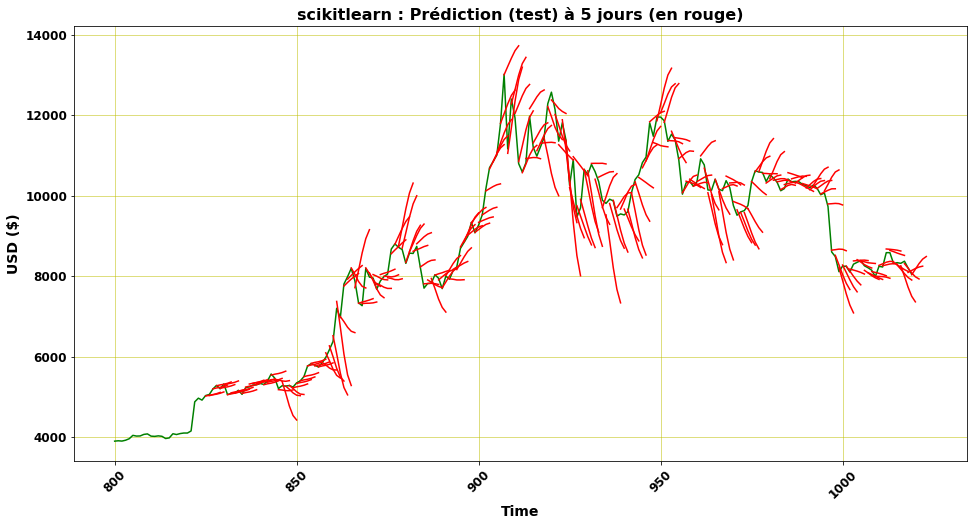

In [838]:
start=800;
end = 1020;
plt.figure(figsize=(16, 8))
plt.plot(range(start,end),df_open[start:end], color='g')
for i in range(start,end-nb_know):
    plt.plot(range(i+nb_know,i+nb_know+nb_predict),model_skt.predict(X[i:i+1])[0], color='r')
plt.title('scikitlearn : Prédiction (test) à 5 jours (en rouge)', weight='bold', fontsize=16)
plt.xlabel('Time', weight='bold', fontsize=14)
plt.ylabel('USD ($)', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.yticks(weight='bold', fontsize=12)
plt.grid(color = 'y', linewidth = 0.5)

## b) Keras https://keras.io/about/

cette partie reproduit la partie précédente avec un autre outil Keras

In [839]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import plot_model
from sklearn.metrics import r2_score
import keras.optimizers

Construction du modèel il est possible d'enchainer différents bloc (réseau) avec même des choix d'interconnection

In [840]:
model_keras = Sequential()
model_keras.add(Dense(2, input_dim=2*nb_know, activation='relu',name='couche1'))
#model_keras.add(Dense(5, activation='relu',name='couche2'))
model_keras.add(Dense(nb_predict,name='sortie'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 7)                 357       
_________________________________________________________________
dense_20 (Dense)             (None, 5)                 40        
Total params: 397
Trainable params: 397
Non-trainable params: 0
_________________________________________________________________


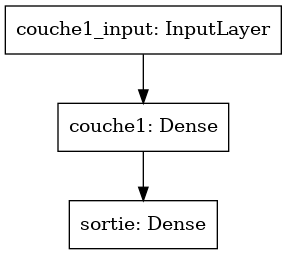

In [841]:
plot_model(model_keras)

Etape de compilation 
loss : mse (MeanSquaredError) ref https://keras.io/api/losses/
optimiser : SGD (Gradient Descent) ref https://keras.io/api/optimizers/

In [842]:
optimizer = keras.optimizers.Adam() # ref https://www.kaggle.com/residentmario/keras-optimizers
model_keras.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

In [843]:
X_train=np.array(X_train)
Y_train=np.array(Y_train)

In [844]:
model_keras.fit(X_train, Y_train, epochs=2,verbose =1, batch_size=1)

Epoch 1/2
800/800 [==============================] - 3s 2ms/step - loss: 44054146.6078 - accuracy: 0.1969
Epoch 2/2
800/800 [==============================] - 2s 3ms/step - loss: 43882787.2609 - accuracy: 0.1484


In [845]:
metrics.r2_score(Y_train, model_keras.predict(X_train)) # sur echantillon d'apprentissage

-2.5246151921762836

In [846]:
metrics.r2_score(Y_test, model_keras.predict(X_test)) # sur echantillon d'apprentissage

-21.468818715175296

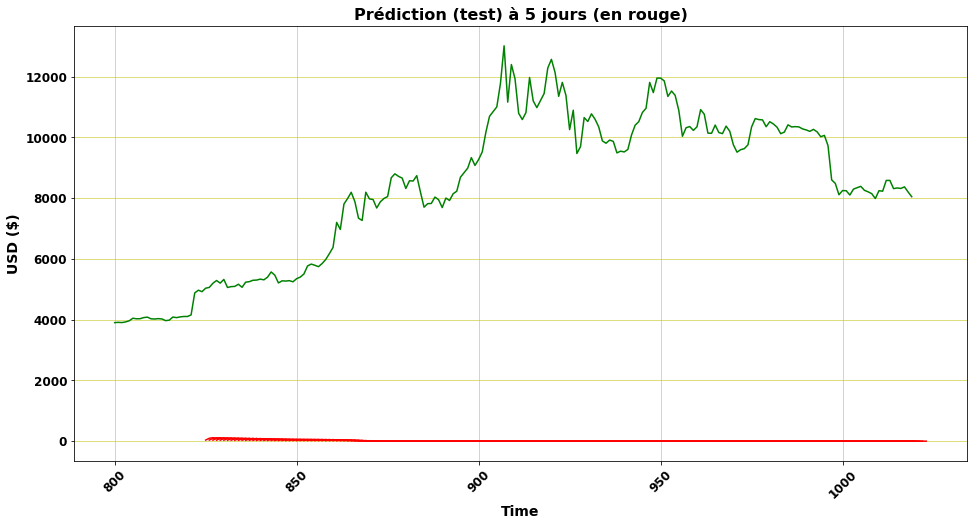

In [847]:
start=800;
end = 1020;
plt.figure(figsize=(16, 8))
plt.plot(range(start,end),df_open[start:end], color='g')
for i in range(start,end-nb_know):
    plt.plot(range(i+nb_know,i+nb_know+nb_predict),model_keras.predict(X[i:i+1])[0], color='r')
plt.title('Prédiction (test) à 5 jours (en rouge)', weight='bold', fontsize=16)
plt.xlabel('Time', weight='bold', fontsize=14)
plt.ylabel('USD ($)', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.yticks(weight='bold', fontsize=12)
plt.grid(color = 'y', linewidth = 0.5)